# __ECL__ 2023-24

## Text Mining 

* __Objectifs__ : apprendre par mimétisme à partir d'exemples
- Appliquer de multiples techniques/méthodes et donner un tableau comparatif 

### Traitements effectués (et les scores) en vue de "choisir" le meilleur modèle

**Préparation** :        
- Codage Tf (Term frequency) puis TfIdf (Term frequency Inverse Document Frequency)    


**Data Mining**     
* Méthode AD : Un seul Arbre de Décision : score 0.7236
* Méthode RF : Random Forest (50) : score 0.83688
* Evaluation : ROC de RF (AUC = 0.91)
* Méthode : Logit : score 0.83176
* Méthode : MNB : score 0.83776
* Méthode : RF avec variation des profondeurs et nombres d'estimateurs
<br>
    - clf151,70 (Profondeur=70, arbres=151) : score =  0.8512  
</br>
* Méthode : RF avec 200 arbres / depth 100 : score = 0.85312
* Méthode : GBoost : score = 0.81416
* Méthode : XGBoost : score = 0.85504
* Méthode : SVM (avec classification LinearSVC): score = 0.80736
* Méthode : SVM (avec classification SVC): score = 0.87016

<font size="4">On décide de choisir Logit pour la suite</font>
* Méthode : Logit : score = 0.90056
* Méthode : Logit avec XV : score = 0.918

<font size="4">On délaisse les n-grams (on revient au mono-gram)</font>
* Méthode : RF (sur ce résultat SVD): score = 0.70168
* Méthode : Logit (sur ce résultat SVD) : 0.85528

<font size="4">Word2Vect</font>
* Méthode : Logit sur ce Doc2Vect : score = 0.62024


In [1]:
import os,sys

# 1- Les données

Elles proviennent du fichier movie_reviews.csv.


## 1.1 - Chargement des données

On charge directement le fichier csv fourni.


In [3]:
import csv
import pandas as pd
csv_txt='./movie_reviews.csv'
df_movie_reviews = pd.read_csv(csv_txt, header=0) 
df_movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 1.2- Préparation des données     
### 1.2.1) Conserver les colonnes utiles    
Les 2 colonnes du data frame sont utiles.

Vérifions que nous avons bien 2 colonnes :

In [3]:
print(df_movie_reviews.shape)

(50000, 2)


### 1.2.2) Renommage  des colonnes (attributs)   
Pour plus de clarté, on **renomme** les colonnes des données en 'Avis' et 'Polarite'
* __Avis__ est l'avis exprimé
* __Polarite__ est l'opinion (sentiment) (0 ou 1 : négatif ou positif)

In [4]:
df_movie_reviews=df_movie_reviews.rename(columns = {'review': 'Avis', 'sentiment' : 'Polarite'}) 
df_movie_reviews

,Avis,Polarite
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


on vérifie les attributs :

In [5]:
df_movie_reviews.columns

Index(['Avis', 'Polarite'], dtype='object')

__Info : Combien de chaque polarité__ ?

In [6]:
# Le bon groupement
df_movie_reviews.groupby(['Polarite']).count()

,Avis
Polarite,
negative,25000
positive,25000


# 2- Vers l'analyse des "avis" (*sentiments*)
## 2.1- Répartition des données pour l'analyse
On les divise en 2 ensembles d'__apprentissage__ et de __test__

__On découpe en train and test : par défaut 75% et 25%__

In [5]:
# On découpe en train and test : par défaut 75% et 25%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_movie_reviews[["Avis"]], df_movie_reviews['Polarite'])

__Combien dans chaque paquet train / test ?__

In [8]:
X_train.shape  # les dimensions : (nb_lignes, nb_cols)

(37500, 1)

In [9]:
X_test.shape

(12500, 1)

## 2.2- Calcul de la matrice numérique 

#### 2.2.1 : Stemming et Lemmatization  de notre corpus

**On filtre les mots (lemmatization) pour ne garder que les mots significatifs, ensuite on calcule la matrice TfIdf**

Ces deux actions peuvent être regroupées dans un **pipeline**    
On importe d'abord quelques outils.

Importation du nécessaire

In [10]:
if False : # SI déjà fait, ne pas refaire
    !pip install textblob
    import nltk
    nltk.download('brown')

In [6]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Amaury\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [7]:
import nltk
from nltk.corpus import stopwords
import numpy as np

# Une seule fois :
if False : # Si déjà fait
    nltk.download('wordnet')
    nltk.download('words')
    nltk.download('punkt')    
    nltk.download('averaged_perceptron_tagger')
    nltk.download('brown')
    nltk.download('stopwords')
    nltk.download('omw-1.4')   

In [8]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob, Word

import string

# Initialisation du "Wordnet Lemmatizer"
lemmatizer = WordNetLemmatizer()


from nltk.corpus import brown  # Il y a davantage de mots ici
words = set(brown.words())

stop_words=set(stopwords.words('english')); # ";" pour ne pas avoir les résultats !

### 2.2.1.1 Lemmatization

__On définit notre lemmatizer qui pré-traitera  le corpus!__
1) vérifier que nos "mots" sont parmi les mots acceptables (non "usuels") : dans "words"
2) enlever les mots usuels (stopwords)
3) enlever qq mots étranges
4) enlever les ponctuations
5) etc.
6) Lemmatiser !    

N.B. 'le' et 'u' sont mis "à la main" !

In [9]:
def lemma(texte) :
    #renvoie lemmatizer.lemmatize(texte)
    return [lemmatizer.lemmatize(t) for t in word_tokenize(texte) if \
            t.lower() in words and \
            t.lower() not in stop_words \
            # cas des strs spécifiques non filtrés
            and t not in ["''", '--', '1.2', '1/2', '18th', '2-3', '20th', '4.00', '4.2', '``', 'le', 'u', 'la']\
            #and t.lower() not in word_tokenize(stop_words).encode() \ # génère un pb de 'byte' ?!
            and t.lower() not in string.punctuation and not t.isdigit()]

__Appliquer puis afficher quelques informations sont le corpus restant__

In [15]:
from sklearn.feature_extraction.text import CountVectorizer


count_vec_lemmatise = CountVectorizer(tokenizer=lemma, stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=0.0, max_features=None)

# Transformer les données en  bag of words
count_train = count_vec_lemmatise.fit(df_movie_reviews["Avis"])

bag_of_words_of_corpus = count_vec_lemmatise.transform(df_movie_reviews["Avis"])

# On enlève qq termes inutiles qui nous ont échappés (qui ont été créés par lemmatize)
# Il s'agit d'un Dict de Python.
for terme_a_jeter in ['n', 'u', 'ft'] :
    count_train.vocabulary_.pop(terme_a_jeter, terme_a_jeter+" n'y est ps !")


# Quelques prints 
print("Il y a ", len(count_train.vocabulary_), " termes dans le vocabulaire\n")

# Print Les 50 premiers termes
print("Les 50 premiers termes:\n{}".format(np.array(count_vec_lemmatise.get_feature_names_out()[:50])))
print("\nTous les 50 termes:\n{}".format(np.array(count_vec_lemmatise.get_feature_names_out()[::50]))) # Tous les 50 termes
#print(type(count_train.vocabulary_))
#print("Vocabulary content:\n {}".format(count_train.vocabulary_))

#les 50 premiers mots et leur nbr d'occurrence
print("\nLe nbr d'occurrence des 50 premiers termes :")
print([(k,v)  for k,v in count_train.vocabulary_.items()][:50])

print("\nLe nbr d'occurrence des 50 premiers termes :")
print([(k,v)  for k,v in count_train.vocabulary_.items()][-50:])

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


Il y a  22970  termes dans le vocabulaire

Les 50 premiers termes:
["'20s" "'30s" "'38" "'48" "'50" "'51" "'53" "'54" "'55" "'58" "'60"
 "'60s" "'61" "'76" "'90s" "'bout" "'em" "'fess" "'im" "'low" "'most"
 "'nother" "'nuff" "'pache" "'round" "'till" "'way" '-ing' '-ism' '0.1'
 '0.10' '0.2' '0.5' '1,000' '1,000,000' '1,400' '1,500' '1,600' '1,700'
 '1-0' '1-1/2' '1-3' '1.0' '1.00' '1.07' '1.1' '1.25' '1.5' '1.8' '1/3']

Tous les 50 termes:
["'20s" '1/4' '1950s' '26-year-old' '4.0' '6.3' 'aback' 'abrupt'
 'accentuated' 'accounting' 'acreage' 'additionally' 'admitted'
 'advertisement' 'afflicted' 'agin' 'airport' 'all-important' 'ally'
 'ambiance' 'amusing' 'anguish' 'anterior' 'apathetic' 'applicable'
 'approximation' 'aristocracy' 'arterial' 'aspen' 'associate' 'atomic'
 'attribute' 'authorizes' 'avocation' 'baby-sitter' 'balanced'
 'bankruptcy' 'bartender' 'bawling' 'bedlam' 'behaviorally' 'benefactor'
 'better-than-average' 'billing' 'blackened' 'blessing' 'bloodshot' 'boar'
 'boltin

In [13]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from pattern.en import lemma
from sklearn.feature_extraction.text import CountVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        #return [lemma(t) for t in word_tokenize(articles) if t.lower() in words]

        return [lemma(t) for t in word_tokenize(articles) if t.lower() in words and \
                t.lower() not in stop_words \
                #and t.lower() not in word_tokenize(stop_words).encode() \ # génère un pb de 'byte' ?!
                # cas des strs spécifiques non filtrés
                and t not in ["''", '--', '1.2', '1/2', '18th', '2-3', '20th', '4.00', '4.2', '``']\
                and t.lower() not in string.punctuation and not t.isdigit()]
                

### 2.2.2- Etape TfIdf



**Calcul du TfIdf de notre corpus**

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer


TfIdf_lemmatise = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", 
                    smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
# max_df = min_df : par default=1.0

corpus_fitted = TfIdf_lemmatise.fit(df_movie_reviews["Avis"])
train_lemmatise_transformed = corpus_fitted.transform(X_train["Avis"])
test_lemmatise_transformed = corpus_fitted.transform(X_test["Avis"])

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<font size="4"> On a maintenant la matrice TdIdf.</font>
On peut déjà faire des calculs de similarité avec.  


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Un exemple de vecteur
print("Un exemple d'avis : ", np.array(X_test["Avis"])[0])

indice_query=1

# QQ affichages : on le refait ensuite (voir query_TFIDF)
#vecteur = TfIdf_lemmatise.transform([np.array(X_test["Avis"])[indice_query]]) # ZZ : [] important
#print("\nLe vecteur TfIdf : " , vecteur.toarray())
#print("\nLe TfIdf du vecteur : ", vecteur)
# ZZ : ci-dessous, les affichages donnent les indices aussi. Seul les réels = TfIdf
#print("\nET les indices non nuls de ce vecteur : ", end='')
#print(np.nonzero(vecteur.toarray())[1])# Les éléments non nul
#print("**", np.nonzero(vecteur)[1])# Les éléments non nul
print('---------------')

# Pour le cas de l'avis  d'indice indice_query
query_TFIDF = TfIdf_lemmatise.transform([np.array(X_test["Avis"])[indice_query]])
print("\nTFIDF du query :", query_TFIDF)

cosine_similarities = cosine_similarity(query_TFIDF, train_lemmatise_transformed).flatten()
related_product_indices = cosine_similarities.argsort()[:-11:-1]
print("\ncosine_similarities entre les 2 phrases :", cosine_similarities)

print("\nelements non. nuls  du consine : ", cosine_similarities[np.nonzero(cosine_similarities)])
print(cosine_similarities[np.count_nonzero(cosine_similarities, axis=0)])
print("\nLes indices des documents proches du query avec similarité par cosinus p/r à train set:")
print(related_product_indices)

words= np.array(X_test["Avis"])[indice_query]
print("\nLe query = ", words)

# Quelques un des documents proches :
print("\nLes documents proches du Query :", np.array(X_test["Avis"])[indice_query])
for ind in related_product_indices :
    print("un docmument proche :", X_train.iloc[ind][0])
    


Un exemple d'avis :  It's been a while since seeing this the first time, so I watched it again with the second movie in the series. While I realize there is a 3rd movie out that I haven't seen yet, I'll review under the original title...<br /><br />Just from the standpoint of production value, screen writing, and movie making, this movie fails on many levels, though it succeeds on a few as well. What can you expect from a low-budget, "B" movie? Not much, and it works from the standpoint of production. However, the writing is certainly disjointed, with little in the way of character development...exactly what I'd expect when there is an agenda to a film. I didn't have a problem with the acting...the cast is solid; however, the screenplay in both movies gives the actors little opportunity to really stretch themselves. Because the film is "Christian," this is predictable, as you can't very well portray violent chaos of the "end times" without also breaking some of the ethics which are nor


TFIDF du query :   (0, 18025)	5.524512282970637
  (0, 17880)	3.7643031426530085
  (0, 17761)	7.16581793425276
  (0, 17572)	2.017050735025303
  (0, 17497)	4.033641846627211
  (0, 17194)	13.686089083979418
  (0, 17168)	3.2511318114051297
  (0, 17167)	3.7709900008760844
  (0, 16546)	4.169609583565283
  (0, 16145)	3.8329333832489003
  (0, 16108)	1.9331317490701816
  (0, 16056)	5.164337934042636
  (0, 15999)	2.1259012689057806
  (0, 15998)	2.4284505786532824
  (0, 15958)	4.247789835032843
  (0, 15594)	9.33972289655635
  (0, 15574)	3.6667163376092327
  (0, 15559)	3.3814118735400167
  (0, 15267)	7.557098407368968
  (0, 14952)	5.230851806876764
  (0, 14812)	3.8650549499123747
  (0, 14774)	2.8339574099282414
  (0, 14598)	3.924714786318711
  (0, 14464)	5.621299567917975
  (0, 14463)	3.888493522884392
  :	:
  (0, 3720)	13.298588578744262
  (0, 3657)	3.474085411156417
  (0, 3557)	4.617861966878657
  (0, 3414)	6.7635324790619755
  (0, 3083)	4.79382102716616
  (0, 2502)	4.165809103931508
  (0, 2215

**Rappel des dimensions de notre corpus (train & test)**

In [31]:
fit_train=train_lemmatise_transformed
fit_test = test_lemmatise_transformed
fit_train.shape, fit_test.shape

((37500, 18040), (12500, 18040))

##  2.3- Partie Analyse 
### 2.3.1- Modèle arbre de décision
**Un seul arbre de décision produira des résultats assez médiocres.**

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(fit_train, y_train)
dt.score(fit_test, y_test)

0.7236

**Le score est assez __médicore__; ce sera une base de comparaison.**

### 2.3.2- Modèle Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(fit_train, y_train)

RandomForestClassifier(n_estimators=50)

In [22]:
clf.score(fit_test, y_test)

0.83688

<font color="red"> **Le score s'est un peu amélioré.**</font>

#### 2.3.2.1- D'autres métriques d'évaluation

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score_t = clf.predict_proba(fit_test)
score_a = clf.predict_proba(fit_train)
print(f"{score_t=}")
print(f"{score_a=}")


score_t=array([[0.42, 0.58],
       [0.76, 0.24],
       [0.4 , 0.6 ],
       ...,
       [0.44, 0.56],
       [0.2 , 0.8 ],
       [0.74, 0.26]])
score_a=array([[0.92, 0.08],
       [0.76, 0.24],
       [0.92, 0.08],
       ...,
       [0.88, 0.12],
       [0.04, 0.96],
       [0.1 , 0.9 ]])


#### 2.3.2.2 Courbe ROC

In [25]:
fpr_t, tpr_t, seuil_t = roc_curve(y_test, score_t[:, 1], pos_label='positive')
fpr_a, tpr_a, seuil_a = roc_curve(y_train, score_a[:, 1], pos_label='positive')

In [26]:
%matplotlib inline

Remarquer l'AUC



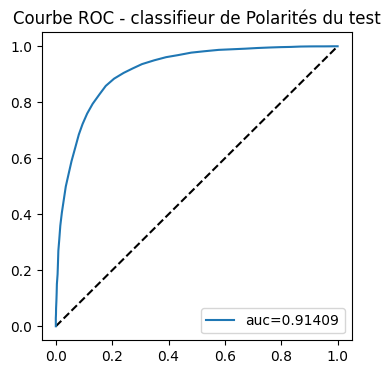

In [27]:
import matplotlib.pyplot as plt
if True :
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax.plot([0, 1], [0, 1], 'k--')
    aucf_t = auc(fpr_t, tpr_t)
    ax.plot(fpr_t, tpr_t, label='auc=%1.5f' % aucf_t)
    ax.set_title('Courbe ROC - classifieur de Polarités du test')
    ax.legend();
    
print("Remarquer l'AUC\n")

#### 2.3.2.3 Comparaison des ROC du train et du test

('Les AUCs train/test:', 0.9999999985777492, 0.9140867531809393)

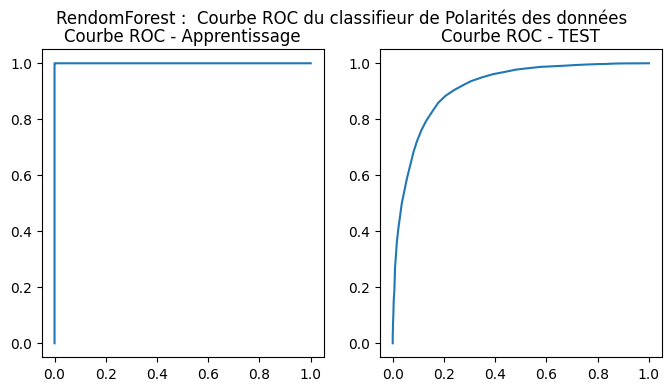

In [28]:
import matplotlib.pyplot as plt

aucf_t = auc(fpr_t, tpr_t)
aucf_a = auc(fpr_a, tpr_a)
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(fpr_a, tpr_a, label='auc=%1.5f' % aucf_t)
axs[0].set_title('Courbe ROC - Apprentissage')
axs[1].plot(fpr_t, tpr_t, label='auc=%1.5f' % aucf_a)
axs[1].set_title('Courbe ROC - TEST')

fig.suptitle('RendomForest :  Courbe ROC du classifieur de Polarités des données')
("Les AUCs train/test:", aucf_a, aucf_t)

# 3. A propose des classifieurs en Text Mining (espace vectoriel) appliqués sur cette DB.

## 3.1-__modèle linéaire__ 

Essayons d'abord avec un __modèle linéaire__ (__logit__).

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
lr.fit(fit_train, y_train)
lr.score(fit_test, y_test)

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.83176

**On constate que le score est similaire au random forest.**

## 3.2- Multinomial Bayesian (MNB)

In [31]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(fit_train, y_train)
mnb.score(fit_test, y_test)

0.83776

**On obtient encore un bon score**

## 3.3- Retour au RandomForest
* Si on augmente la profondeur de l'arbre, la forêt aléatoire peut __parfois__ être plus performante.

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf20 = RandomForestClassifier(n_estimators=120, max_depth=20)
clf20.fit(fit_train, y_train)
clf20.score(fit_test, y_test)

0.83928

**Le score obtenu n'est pas tellement mieux que celui du random forest moins profond.**  

### 3.3.1 Itération su Random Forest   
Essayons d'autre combinaisons des paramètres dans une itération

In [33]:
from sklearn.ensemble import RandomForestClassifier
clfs=[("clf"+str(N)+','+str(depth), RandomForestClassifier(n_estimators=N, max_depth=depth))  for N in range(1,200,50) for depth in range(10,100,20)]
for nom, _clf_ in clfs :
    _clf_.fit(fit_train, y_train)
    print(nom, ' : score = ', _clf_.score(fit_test, y_test))
    

clf1,10  : score =  0.6004
clf1,30  : score =  0.66536
clf1,50  : score =  0.64
clf1,70  : score =  0.66624
clf1,90  : score =  0.658
clf51,10  : score =  0.81712
clf51,30  : score =  0.83808
clf51,50  : score =  0.8372
clf51,70  : score =  0.83576
clf51,90  : score =  0.83648
clf101,10  : score =  0.82776
clf101,30  : score =  0.84112
clf101,50  : score =  0.84672
clf101,70  : score =  0.84472
clf101,90  : score =  0.84672
clf151,10  : score =  0.82432
clf151,30  : score =  0.8456
clf151,50  : score =  0.84784
clf151,70  : score =  0.8512
clf151,90  : score =  0.84824


**Les dernières combinaisons, possédant plus d'estimations plus profonds, semblent meilleurs. Toutefois, on observe qu'augmenter la profondeur n'implique pas nécessairement un meilleur score.**

### 3.3.2 Deux des meilleures combinaisons

In [34]:
clf50_ = RandomForestClassifier(n_estimators=150, max_depth=90)
clf50_.fit(fit_train, y_train)
clf50_.score(fit_test, y_test)

0.84936

In [35]:
clf50_ = RandomForestClassifier(n_estimators=100, max_depth=70)
clf50_.fit(fit_train, y_train)
clf50_.score(fit_test, y_test)

0.84792

#### 3.3.3.  Et une autre (200 arbres, profondeur max = 100)

In [36]:
clf50 = RandomForestClassifier(n_estimators=200, max_depth=100)
clf50.fit(fit_train, y_train)
clf50.score(fit_test, y_test)

0.85312

**C'est le meilleur modèle jusqu'à présent, mais les progrès sont très faibles.**

## 3.4- Gradient Boost

### 3.4.1- Regular Gradient Boosting
* Un méta-modèle de __gradient boosting__ devrait dépasser les RFs puisque les arbres ne sont plus appris indépendemment les uns des autres.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gbc40 = GradientBoostingClassifier(n_estimators=200, max_depth=40)
gbc40.fit(fit_train, y_train)
gbc40.score(fit_test, y_test)

0.81416

Ce modèle n'a pas réussi à dépasser les Randoms Forests, et est beaucoup plus long à entrainer (environ 2h).

### 3.4.2- Extreme Gradient Boosting

Pour accélérer l'entrainement, nous pouvons utiliser XGBoost car il est parallélisable.

In [42]:
import xgboost as xgb

# XGBoost a besoin des labels 0 et 1 pour l'entrainement
y_train_bis = pd.DataFrame(y_train, columns=['label'])
y_test_bis = pd.DataFrame(y_test, columns=['label'])
y_train_bis = [1 if label == 'positive' else 0 for label in y_train]
y_test_bis = [1 if label == 'positive' else 0 for label in y_test]


xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=200, max_depth=40)
xgb_model.fit(fit_train, y_train_bis)
xgb_model.score(fit_test, y_test_bis)

0.85504

On obtient notre meilleur modèle jusqu'à présent avec seulement 3min 26s d'entrainement (contre 2h pour GradientBoostingClassifier).

## 3.5- SVM linéaire avec la méthode OneVsRestClassifier

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
modele_one_vs_linear_SVC= OneVsRestClassifier(LinearSVC())
modele_one_vs_linear_SVC.fit(fit_train, y_train)
modele_one_vs_linear_SVC.score(fit_test, y_test)

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.80736

**On constate que SVM se comporte (comme souvent) bien, mais les résultats restent inférieurs à ceux des forests.**

## 3.6- Classifieur SVM avec la méthode OneVsRestClassifier

Même chose mais on utilise la méthode SVM (pour la classification : SVC)


In [32]:
from sklearn.svm import SVC
modele_one_vs_SVC = OneVsRestClassifier(SVC())
modele_one_vs_SVC.fit(fit_train, y_train)
modele_one_vs_SVC.score(fit_test, y_test)

0.87016

**Cette méthode donne ainsi des meilleurs résultats que toutes les méthoes étudiées précédemment.**

# 4- Les n-grammes
L'approche Bag of Word (matrices Tf, TfIdf)  ci-dessus ne tient pas compte ni du contexte, ni de l'ordre des mots. Chaque phrase est convertie en un sac de mots (ou bag of words). 

On va désormais tenir compte de séquences plus ou moins longues à l'aide des __n-grams__.

## 4.1- Utilisation du bi-gram     


**On applique le principe de bi-gramme avec scikit-learn.**

**On lémmatise, puis TfIdf sur les bi-grammes**

### 4.1.1- Appliqué aux données de base.

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)), TfidfTransformer())
pipe2.fit(X_train['Avis'])
fit_train2 = pipe2.transform(X_train['Avis'])
fit_test2 = pipe2.transform(X_test['Avis'])

### 4.1.2- Appliqué aux données lemmatisées

Appliqué aux données lemmatisées. (si Warning, lancez une 2e fois)     
Si Warning, relancer !

In [36]:
count_vec_lemmatise = CountVectorizer(tokenizer=lemma, stop_words="english", analyzer='word', 
                            ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)
pipe2_bis = make_pipeline(CountVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", analyzer='word', 
                            ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None), TfidfTransformer())
pipe2_bis.fit(X_train['Avis'])
fit_train2_bis = pipe2_bis.transform(X_train['Avis'])
fit_test2_bis = pipe2_bis.transform(X_test['Avis'])

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acros', 'afterward', 'alway', 'anythe', 'everythe', 'hundr', 'indee', 'les', 'make', 'nevertheles', 'nothe', 'perhap', 'seriou', 'somethe', 'thu', 'u', 'wherea'] not in stop_words.
  warnings.warn(


## 4.2 - Application de la méthode Logit aux bi-grammes

### 4.2.1 - Données de base

In [37]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(solver='lbfgs')


**Et on 'fit'**

In [38]:
clf2.fit(fit_train2, y_train)

LogisticRegression()

Et on calcule le score

In [39]:
clf2.score(fit_test2, y_test)

0.90056

**L'utilisation des bi-grammes améliore les résultats de façon significative, qui plus est en un temps d'entrainement beaucoup plus faible (environ 1 min).**

### 4.2.2-  Données lemmatisées

In [40]:
from sklearn.linear_model import LogisticRegression
clf2_bis = LogisticRegression(solver='lbfgs')

**Et on 'fit'**

In [41]:
print(clf2_bis.fit(fit_train2_bis, y_train))

LogisticRegression()


ET on calcule le score 

In [42]:
print(clf2_bis.score(fit_test2_bis, y_test))

0.88


Les résultats restent bons, mais la lemmatisation des données ne parait pas donner d'avantage lors de l'entrainement du modèle. On se limitera donc aux données de base par la suite.

## 4.3- Cross-validation


In [46]:
from sklearn.linear_model import LogisticRegressionCV
clf2_ = LogisticRegressionCV(cv=5, n_jobs=2, max_iter=200)
clf2_.fit(fit_train2, y_train)
clf2_.score(fit_test2, y_test)

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.918

**L'ajout de la cross-validation permet d'améliorer encore plus le score du modèle.**

Toutefois, ceci coute beaucoup plus en temps d'entrainement, passant de 1min sans CV à 37 min avec.

## 4.4-  Application de  MNB (sur les données de base)
**D'abord MNB sur les données de de base !**

In [47]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(fit_train2, y_train)
mnb.score(fit_test2, y_test)

0.89408

Ce score est encourageant, regardons comment nous pouvons améliorer le modèle.

## 4.5- Réduction de dimension avec une SVD

On choisit la méthode TruncatedSVD plutôt que l'ACP dont l'implantation ne supporte pas les features creux(sparses).

On applique ensuite la méthode random forest à ce résultat SVD.

In [16]:
from sklearn.decomposition import TruncatedSVD

pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['Avis'])
fit_train_svd = pipe_svd.transform(X_train['Avis'])

### 4.5.1-  Application du  RF à ce résultat SVD

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf_svd = RandomForestClassifier(n_estimators=50)
clf_svd.fit(fit_train_svd, y_train)

fit_test_svd = pipe_svd.transform(X_test['Avis'])
clf_svd.score(fit_test_svd, y_test)

0.70168

Les résultats de cette première tentative d'amélioration ne sont pas très bons par rapport à la méthode random forest sans SVD. Testons autre chose.

### 4.5.2- Application de la Regression logistique à ce résultat SVD 

In [20]:
from sklearn.linear_model import LogisticRegression

lr_svd = LogisticRegression(solver='lbfgs')
lr_svd.fit(fit_train_svd, y_train)
lr_svd.score(fit_test_svd, y_test)

c:\Users\Amaury\.conda\envs\deeplearning\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.85528

Ce score est meilleur que celui obtenu avec un random forest, mais reste inférieur à celui de la methode Logit sans SVD.

**Cela veut dire qu'il faut garder davantage de dimensions.**

# 5- word2vec
__word2vec__ est une projection (comme ACP/SVD) en ce sens qu'il réduit les dimensions. 

__word2vec__ est plus d'une ACP non linéaire car il prend en compte le contexte.

In [22]:
if False :
    !pip install gensim
    !pip install Levenshtein

### 5.1- Tokenisation du texte des Avis

In [24]:
from gensim.utils import tokenize
Avis = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['Avis']]

### 5.2- Application de Wor2Vec

**N.B. : Les paramètres d'apprentissage du modèle Word2Vec ne sont pas toujours décrit de façon explicite.**


In [25]:
from gensim.models import word2vec
#model = word2vec.Word2Vec(Avis, size=300, window=20, min_count=2, workers=1, iter=100)
model = word2vec.Word2Vec(Avis,  window=20, min_count=2, workers=1)

In [26]:
# On sauve le modèle entrainé
model.save('trained_word2vec.bin')

# 6- Vers Doc2Vect (manuel & expérimental)

**Pour chaque phrase, on fait la somme des vecteurs associés aux mots qui la composent ou pas si le mot n'est pas dans le vocabulaire.**

* Proche de __doc2vect__
* Il y a probablement des fonctions déjà prêtes à l'emploi mais la documentation de gensim n'était pas assez explicite 

Réfs : 

Efficient Estimation of Word Representations in Vector Space     

Distributed Representations of Words and Phrases and their Compositionality.

In [27]:
import numpy as np

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["Avis"], model)
wv_train_feat.shape

(37500, 100)

### 6.1 Logit sur word2vect

In [28]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(wv_train_feat, y_train)

wv_test_feat = word2vec_features(X_test["Avis"], model)

clfwv.score(wv_test_feat, y_test)

0.62024

La performance est bien moindre et encore  moindre que la performance obtenue avec l'ACP. 
Il faudrait 'tuner' les hyperparamètres de l'apprentissage ou réutiliser un model appris sur un corpus similaire aux données initiales mais bien plus grand. 

# Conclusion

Sur cette base de données, le meilleur modèle semble être la régression logistique avec cross validation avec un score de 0.918.

Toutefois, on peut imaginer d'autres modèles qui ont le potentiel de battre celui-ci. Par exemple, une régression logistique sur Word2Vect entrainé sur une beaucoup plus grande base de données, ou un Extreme Gradient Boosting utilisant plus d'estimateurs plus profonds.